# From workflow to widget: customizing napari

The napari application uses a backend for the graphical user interface (GUI) called [Qt](https://doc.qt.io). A key feature of this framework is the use of [widgets](https://doc.qt.io/qt-6/qtwidgets-index.html), which are composable, basic UI elements. napari not only utilizes these for its UI, but also enables you can add your own as `dockable` elements. In fact, the layer controls, layer list, and napari console are all such dockable containers of Qt widgets.

There are a number of ways to go about creating your own widgets, you can see [an in-depth overview in the napari documentation](https://napari.org/dev/howtos/extending/magicgui.html). By far the simplest is to rely on the fact that napari supports the use of [`magicgui`](https://pyapp-kit.github.io/magicgui/), a Python library for quick and easy building of GUIs. A key feature of `magicgui` is autogeneration of GUIs from functions and dataclasses, by mapping Python type hints to widgets.

In this module, we will implement elements of our previous workflow as functions and then use [`magicgui.magicgui`](https://pyapp-kit.github.io/magicgui/api/magicgui/#magicguimagicgui) decorator on those functions to return us compound widgets that we can use to make exploring the parameters easier in the GUI. For a nice overview of the `magicgui` decorators, see [the official documentation](https://pyapp-kit.github.io/magicgui/decorators/).

## `binder` setup

In [1]:
# this cell is required to run these notebooks on Binder. Make sure that you also have a desktop tab open.
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    os.environ['DISPLAY'] = ':1.0'

## Loading data

Let's get everything set up, based on the previous notebook:

In [2]:
from skimage import io

nuclei_url = 'https://raw.githubusercontent.com/kevinyamauchi/napari-spot-detection-tutorial/main/data/nuclei_cropped.tif'
nuclei = io.imread(nuclei_url)

spots_url = 'https://raw.githubusercontent.com/kevinyamauchi/napari-spot-detection-tutorial/main/data/spots_cropped.tif'
spots = io.imread(spots_url)

In [3]:
import napari
from napari.utils import nbscreenshot

# create the napari viewer
viewer = napari.Viewer()

# add the nuclei image to the viewer
viewer.add_image(nuclei, colormap = 'I Forest', blending = 'minimum')

# add the spots image to the viewer
viewer.add_image(spots, colormap = 'I Orange', blending='minimum')

<Image layer 'spots' at 0x7fd9e6530050>

## A basic filtering function

Now let's write a function that takes an array and a `sigma` value and performs the 
high-pass operation.

In [4]:
import numpy as np
from scipy import ndimage as ndi

def gaussian_high_pass(image, sigma):
    low_pass = ndi.gaussian_filter(image, sigma)
    high_passed_im = (image - low_pass).clip(0)
    
    return high_passed_im

We can test our function, in similar fashion as before:

In [5]:
high_passed_spots = gaussian_high_pass(spots, 2)

viewer.add_image(high_passed_spots, colormap="I Blue", blending="minimum")

<Image layer 'high_passed_spots' at 0x7fd9e616ce90>

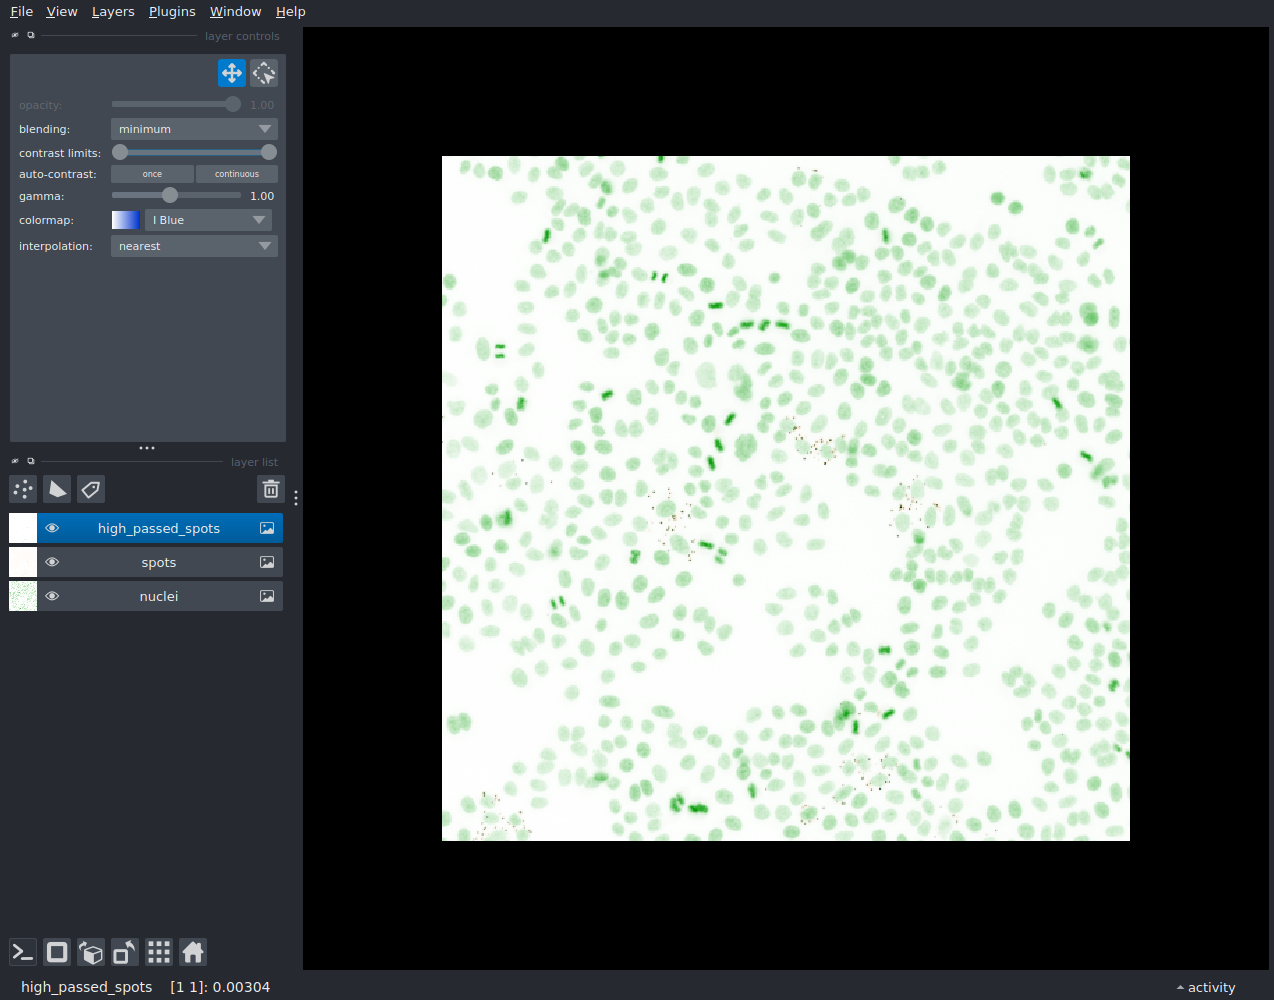

In [6]:
nbscreenshot(viewer)

## Obtaining a basic widget using the `@magicgui` decorator

Now lets modify the function slightly, by providing type annotations and a docstring, to 
leverage napari `magicgui` integration.

````{tip}
A brief note about type hints:  
Type hints are not enforced at runtime, **but** they can still raise `NameError` exceptions if not defined or imported.
To avoid that, we are putting the napari types in quotes to make them "forward references", because we have
not imported them. Alternatively, we could have imported them. A third option is to import:

```python
from __future__ import annotations 
```

This would permit us to drop the quotes from the type hints.  
For more information, see the official Python documentation for: 
[type hints in Python](https://peps.python.org/pep-0484/), [forward references](https://peps.python.org/pep-0484/#forward-references),and [annotations](https://peps.python.org/pep-0563/).

````

In [7]:
from magicgui import magicgui

@magicgui
def gaussian_high_pass(
        image: "napari.types.ImageData", sigma: float = 2
        ) -> "napari.types.ImageData":
    """Apply a gaussian high pass filter to an image.

    Parameters
    ----------
    image : np.ndarray
        The image to be filtered.
    sigma : float
        The sigma (width) of the gaussian filter to be applied.
        The default value is 2.
    
    Returns
    -------
    high_passed_im : np.ndarray
        The image with the high pass filter applied
    """
    low_pass = ndi.gaussian_filter(image, sigma)
    high_passed_im = (image - low_pass).clip(0)
    
    return high_passed_im

We have our `magicgui` decorated function and we've annotated it with the napari types.
Now, the object `gaussian_high_pass` is both a (compound) widget and a callable function. 
Let's add it to the viewer.

In [8]:
viewer.window.add_dock_widget(gaussian_high_pass)

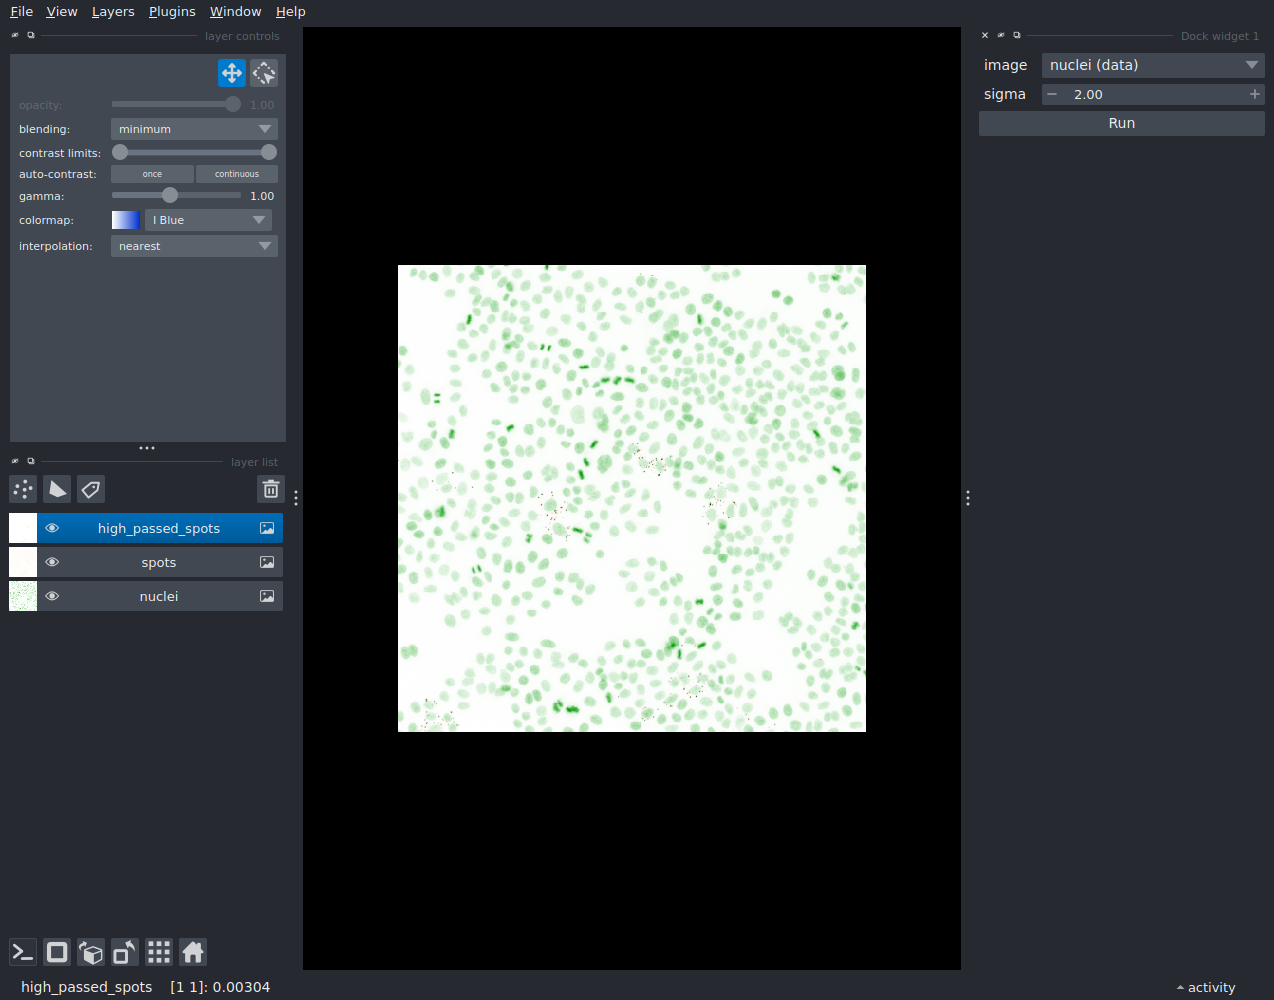

In [9]:
nbscreenshot(viewer)

Notice that because we told `magicgui` that our function will use not just any numpy array, but 
specifically `ImageData`—the data of an Image layer—and that it will also return that, `magicgui`
generated UI widgets for selecting an Image layer--if you add another layer type, it won't show
up in the dropdown!
Press the `Run` button and you will see that a new Image layer is added with the results of our
function—again thanks to autogeneration from `magicgui`.

In [10]:
# we'll call the widget to simulate clicking `Run`
gaussian_high_pass(viewer.layers['spots'].data)

array([[0.00084478, 0.00347908, 0.00447733, ..., 0.00014444, 0.        ,
        0.        ],
       [0.00049922, 0.00303904, 0.00163708, ..., 0.00112132, 0.        ,
        0.        ],
       [0.        , 0.00024094, 0.        , ..., 0.00195232, 0.00035587,
        0.        ],
       ...,
       [0.0015178 , 0.0008351 , 0.00010436, ..., 0.        , 0.00015427,
        0.00047611],
       [0.00136203, 0.00138009, 0.00107976, ..., 0.        , 0.        ,
        0.00208043],
       [0.00215613, 0.00369759, 0.0032546 , ..., 0.        , 0.0006618 ,
        0.00307453]], dtype=float32)

Note that we are just returning `ImageData`, so there is no information passed about colormaps, blending, etc. If we want to specify that, we would need to annotate as [`LayerDataTuple`](https://napari.org/stable/guides/magicgui.html#returning-napari-types-layerdatatuple). (We will do this in the next example.)
For now you will need to manually or programmatically set any colormap/blending settings. (Let's also hide the previous filtering output.)

In [11]:
viewer.layers[-1].blending = "minimum"
viewer.layers[-1].colormap = "I Blue"
viewer.layers['high_passed_spots'].visible = False

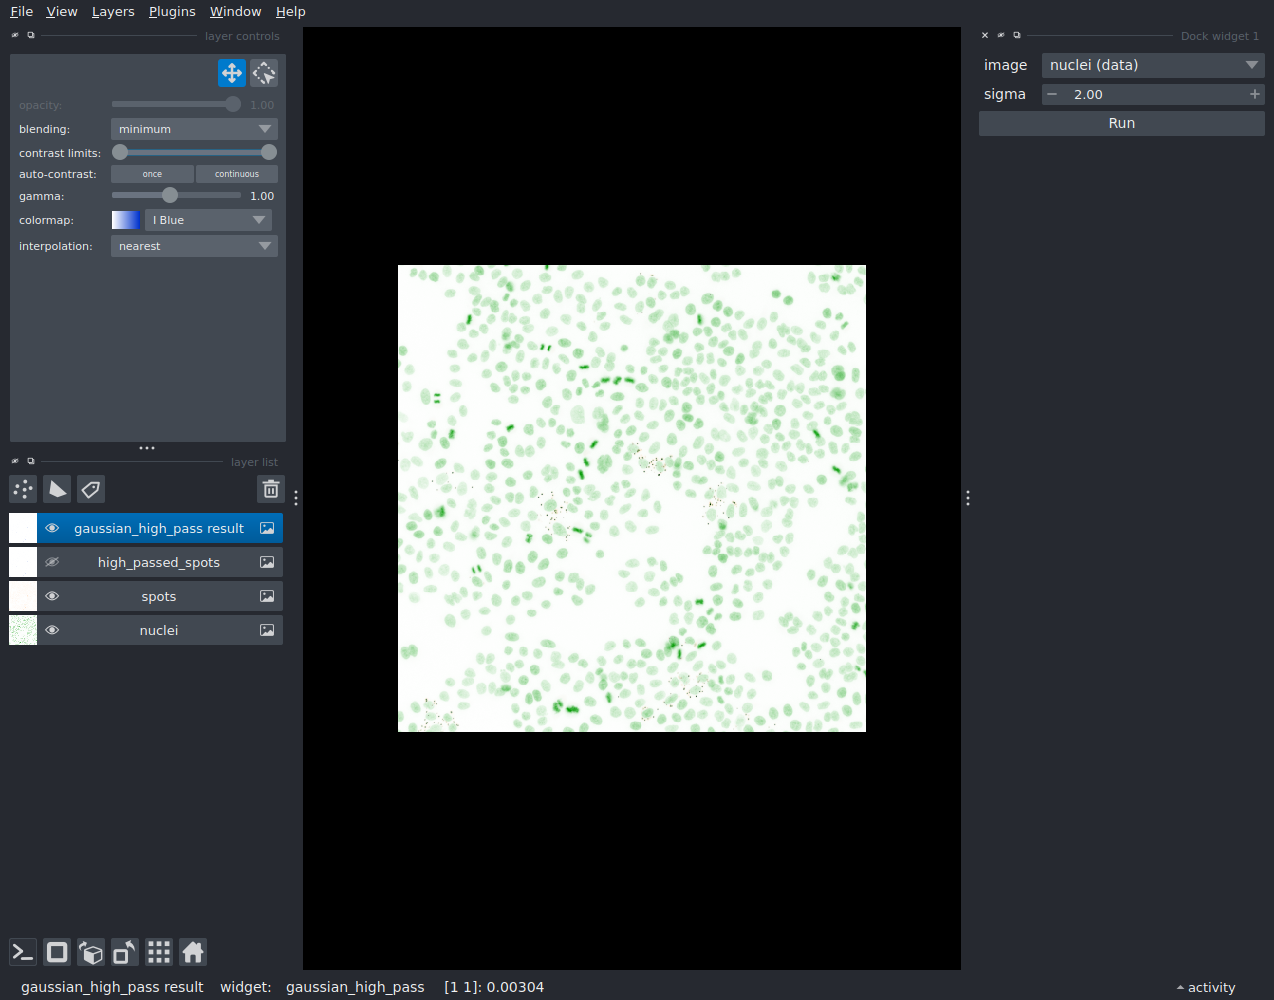

In [12]:
nbscreenshot(viewer)

However, if you press `Run` again, the data for that layer will be updated in place, so
you can change the `sigma` value and see the updated result.

```{tip}
Hover over the labels `image` and `sigma` -- the names of the parameters we passed to the function.
You should see tooltips with the docstring information! How cool is that?
```

Our `gaussian_high_pass` object *is the widget*, so we can easily get the value of the current setting:

In [13]:
gaussian_high_pass.sigma.value

2.0

At the same time, `gaussian_high_pass` remains a callable function. Let's call it normally, to check 
that the function is still working as expected. Remember, type hints are not enforced by Python at runtime, 
so nothing should have changed.

In [14]:
test_output = gaussian_high_pass(spots, 2)
test_output.shape

(492, 494)

This means that if you have a script or module you can import the function and use it as normally
*or* use it as a widget in napari.

Let's make the the widget more dynamic and user-friendly, by giving `magicgui` some extra information.
Let's ask for a slider for the `sigma` parameter and lets have the function be auto-called
when the slider is changed.

But first, lets remove the previous widget.

In [15]:
viewer.window.remove_dock_widget("all")

In [16]:
@magicgui(
        auto_call=True, 
        sigma={"widget_type": "FloatSlider", "min": 0, "max": 20}
        )
def gaussian_high_pass(
        image: "napari.types.ImageData", sigma: float = 2
        ) -> "napari.types.ImageData":
    """Apply a gaussian high pass filter to an image.

    Parameters
    ----------
    image : np.ndarray
        The image to be filtered.
    sigma : float
        The sigma (width) of the gaussian filter to be applied.
        The default value is 2.
    
    Returns
    -------
    high_passed_im : np.ndarray
        The image with the high pass filter applied
    """
    low_pass = ndi.gaussian_filter(image, sigma)
    high_passed_im = (image - low_pass).clip(0)
    
    return high_passed_im

In [17]:
viewer.window.add_dock_widget(gaussian_high_pass)

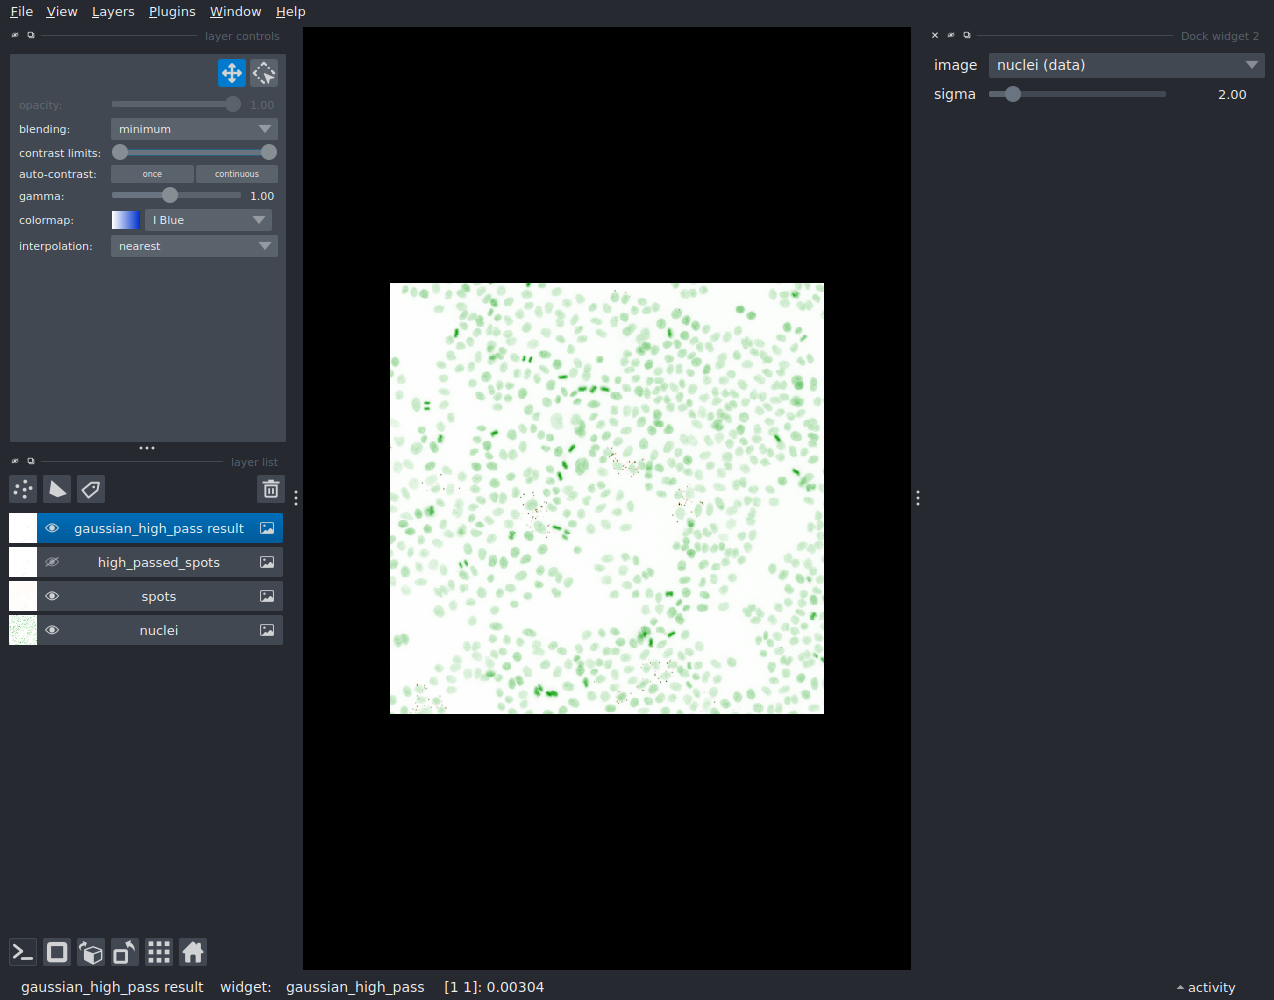

In [18]:
nbscreenshot(viewer)

Now you can play with the slider until you get the effect you want in the GUI and then return the value:

In [19]:
gaussian_high_pass.sigma.value

2.0

Or you can *set the value*:

In [20]:
gaussian_high_pass.sigma.value = 3

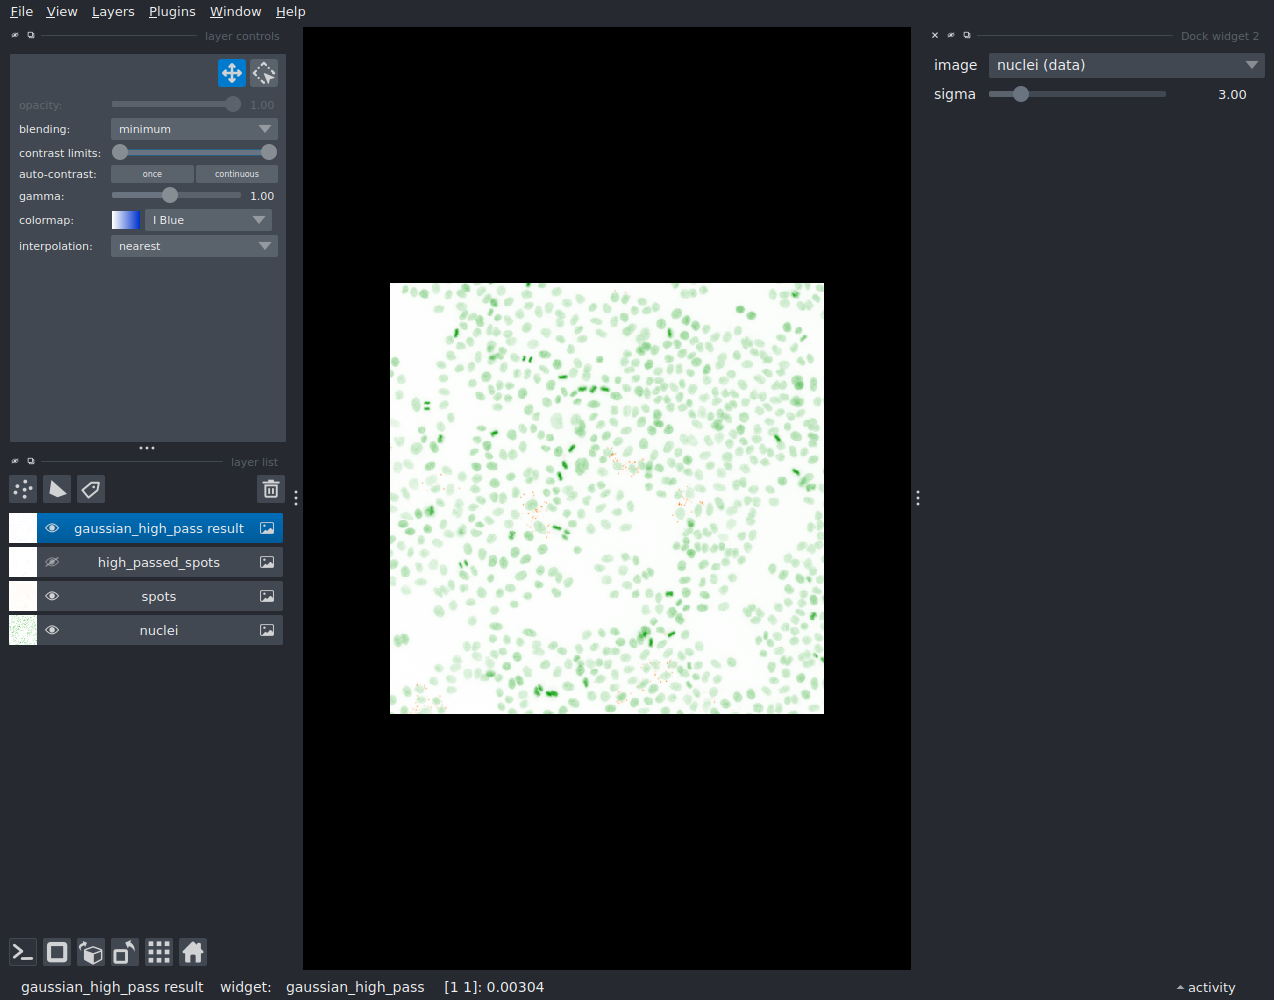

In [21]:
nbscreenshot(viewer)

## A more complex example

Finally, lets make a widget for the whole workflow as a function. We will need to write a function
and then properly annotate it such that `magicgui` can generate the widgets. This time we are also
starting with image layer (data), but then we want a Points layer with points. We could again return 
just the layer data using `napari.types.PointsData`. But lets get a nicer Points layer instead, so 
we will return a LayerDataTuple.  

If `detect_spots()` returns a `LayerDataTuple`, napari will add a *new layer* to
the viewer using the data in the `LayerDataTuple`. Briefly:
- The layer data tuple should be: `(layer_data, layer_metadata, layer_type)`
- `layer_data`: the data to be displayed in the new layer (i.e., the points
      coordinates)
- `layer_metadata`: the display options for the layer stored as a
      dictionary. Some options to consider: `symbol`, `size`, `face_color`
- `layer_type`: the name of the layer type as a string—in this case `'Points'`  

For more information on using the `LayerDataTuple` type, please see [the documentation](https://napari.org/stable/guides/magicgui.html#returning-napari-types-layerdatatuple).

Also let's change the `image` argument type hint to `ImageLayer` so that we can access more
properties if we'd like or be able to more easily set the value programmatically.

In [22]:
# again lets remove the previous widget
viewer.window.remove_dock_widget("all")

In [23]:
import numpy as np
from skimage.feature import blob_log

@magicgui
def detect_spots(
        image: "napari.layers.Image",
        high_pass_sigma: float = 2,
        spot_threshold: float = 0.2,
        blob_sigma: float = 2
        ) -> "napari.types.LayerDataTuple":
    """Apply a gaussian high pass filter to an image.

    Parameters
    ----------
    image : np.ndarray
        The image in which to detect the spots.
    high_pass_sigma : float
        The sigma (width) of the gaussian filter to be applied.
        The default value is 2.
    spot_threshold : float
        The relative threshold to be passed to the blob detector.
        The default value is 0.2.
    blob_sigma: float
        The expected sigma (width) of the spots. This parameter
        is passed to the "max_sigma" parameter of the blob
        detector.
    
    Returns
    -------
    points_coords : np.ndarray
        An NxD array with the coordinate for each detected spot.
        N is the number of spots and D is the number of dimensions.
    sizes : np.ndarray
        An array of size N, where N is the number of detected spots
        with the diameter of each spot.
    
    """
    # filter the image layer data
    filtered_spots = gaussian_high_pass(image.data, high_pass_sigma)

    # detect the spots on the filtered image
    blobs_log = blob_log(
        filtered_spots,
        max_sigma=blob_sigma,
        threshold=None,
        threshold_rel=spot_threshold
    )
    
    # convert the output of the blob detector to the 
    # desired points_coords and sizes arrays
    # (see the docstring for details)
    points_coords = blobs_log[:, 0:2]
    sizes = 2 * np.sqrt(2) * blobs_log[:, 2]

    return (points_coords, {"size": sizes, "face_color": "red"}, "Points")

In [24]:
viewer.window.add_dock_widget(detect_spots)

In [25]:
# let's call the widget/function to simulate pressing run
detect_spots(viewer.layers['spots'])

(array([[252., 329.],
        [220., 275.],
        [255., 172.],
        [195., 253.],
        [204., 278.],
        [454., 314.],
        [263., 157.],
        [458.,  30.],
        [250., 355.],
        [ 10., 268.],
        [241., 152.],
        [244., 148.],
        [252., 151.],
        [471.,  56.],
        [290., 178.],
        [433., 315.],
        [217., 260.],
        [253., 335.],
        [202., 258.],
        [266., 348.],
        [455., 308.],
        [449., 318.],
        [278., 159.],
        [259., 166.],
        [272., 327.],
        [258., 177.],
        [464., 287.],
        [218.,  57.],
        [267., 162.],
        [188., 252.],
        [433., 306.],
        [446., 301.],
        [268., 165.],
        [201., 287.],
        [414., 298.],
        [203., 254.],
        [239., 162.],
        [250., 178.],
        [204., 272.],
        [210., 268.],
        [483.,  30.],
        [198., 249.],
        [475.,  43.],
        [481.,  51.],
        [234.,  60.],
        [ 

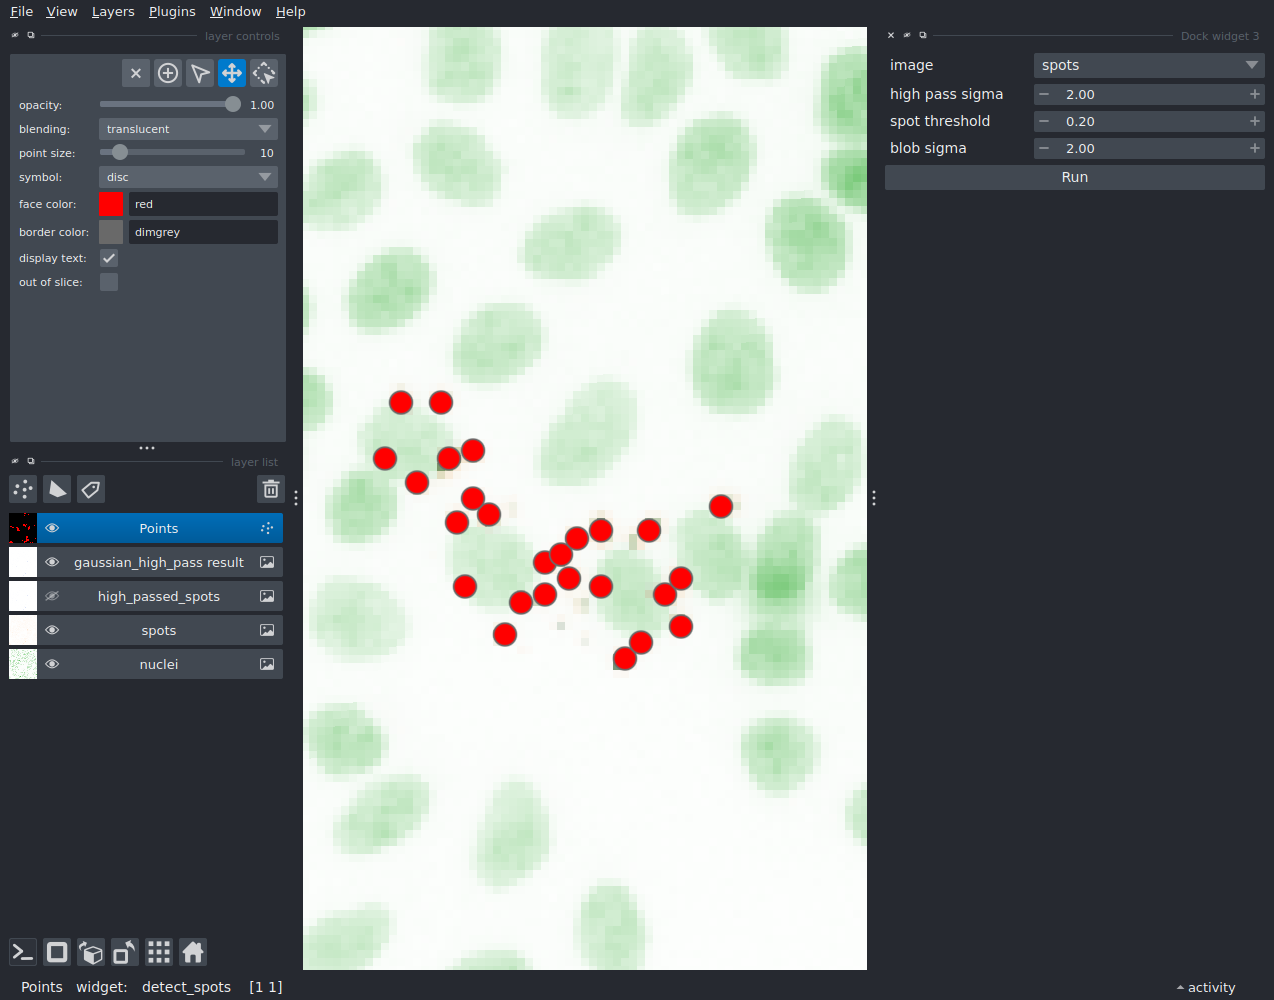

In [26]:
# lets set the dropdown value for the screenshot
detect_spots.image.value = viewer.layers['spots']

# and lets zoom in a bit
viewer.camera.center = (200, 270)
viewer.camera.zoom = 8
nbscreenshot(viewer)

```{tip}
In this notebook we used the `@magicgui` decorator, which turned out function into both a function
and a widget. Another similar option is the `@magic_factory` decorator. This one *does not return a widget instance immediately*. Instead, it turns out function into a "widget factory function" that can be called to *create a widget instance*. This can be more convenient in many cases, if you are writing a library or package where someone else will be instantiating your widget.  
One additional important—and useful!—distinction is that `@magic_factory` gains the `widget_init` keyword argument, which will be called with the new widget each time the factory function is called.
For more details, on the two `magicgui` decorators, see [the official documentation](https://pyapp-kit.github.io/magicgui/decorators/).
```

## Custom keybindings

napari has extensive keyboard shortcuts that can be customized in the Preferences/Settings GUI.
However, it also enables you to bind key-press events to custom callback functions. Again, the 
napari implementation (`bind_key`) is smart, so arguments like the viewer getting the key press or the current
selected layer of a given time will be passed to your function.

Lets try a simple example, to get the number of Points returned by our detector when we press
a key binding. For this, we will want the `bind_key` decorator to pass in a selected Points layer
as an argument to our function that will return the number of detected spots.

In [27]:
from napari.layers import Points

@Points.bind_key("Shift-D")
def print_number_of_points(points_layer: "napari.layers.Points"):
    print("Detected points: ", len(points_layer.data))


Give it a shot in the viewer, you should get a print statement in the notebook, when you press the 
keybinding with a Points layer selected, but not with any other layer type.

```{tip}
We used `print`, so the output ends up in the notebook (or the terminal, REPL, etc.). To get something visible in the 
viewer itself, you can use [`napari.utils.notifications.show_info`](https://napari.org/dev/api/napari.utils.notifications.html).
However, be aware that this won't work when napari was launched from a Jupyter notebook (hopefully fixed in napari 0.5.0): nothing will
happen.
```

Let's call the function to trigger it for the notebook:

In [28]:
print_number_of_points(viewer.layers['Points'])

Detected points:  135


```{important}
At the moment, `bind_key` shortcuts cannot overwrite napari builtin shortcuts, even with `overwrite=True`.
Worse yet, this will silently fail, because the builtin napari keybinding *will* trigger.
```

There are actually a number of other events that you can connect callbacks to, other than just key presses.
For more information, see the [napari events documentation](https://napari.org/stable/howtos/connecting_events.html).


## Conclusions

We've now seen how to how to extend the viewer with custom GUI functionality: widgets and keybindings. 
By using these concepts you can making analyses even more interactive, particularly exploratory/human-in-the-loop
analysis. Additionally, the approach described here, using `magicgui`, can also be directly used to create
a plugin to share with the world.